# Indeed Job Analysis

## Imports

In [8]:
# Pandas is an open source data analysis and manipulation tool
import pandas as pd 

# os gives access to the operating system
import os

# regex library
import re

# Natural language toolkit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# library to create visualizations
import seaborn
# library to create visualizations
import matplotlib.pyplot as plt


# only run below once
#import nltk
#nltk.download("punkt")
#nltk.download("stopwords")

## Load data

In [21]:
# folder path to data
folder_path = "/Users/jan/Documents/7.Semester/Datenanalyse in der Praxis/SeminarArbeit/Data"
# change directory to folder path
os.chdir(folder_path)
# initialize list for all csvs
All_CSVs=[]
#iterate over every file in folder
for file in os.listdir():
    if file.endswith(".csv"):   
        # csv to dataframe
        df =pd.read_csv(file, index_col=[0], header=0)
        # append data frame to all csvs list
        All_CSVs.append(df)
# concat all jobs to one data frame
all_jobs = pd.concat(All_CSVs, axis=0, ignore_index=True)

# drop duplicates
all_jobs = all_jobs.drop_duplicates(subset=["1","2","5"],keep="last")

# reindex
all_jobs = all_jobs.reset_index(drop=True)

# rename
all_jobs = all_jobs.rename(columns={'0': 'job_id',"1" : "job_title","2" : "company_name","3" : "company_location","4" : "type_of_job","5" : "job_description","6" : "date_info"})



In [16]:
all_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_title         38 non-null     object
 1   company_name      38 non-null     object
 2   company_location  11 non-null     object
 3   type_of_job       9 non-null      object
 4   job_description   38 non-null     object
 5   date_info         38 non-null     object
dtypes: object(6)
memory usage: 1.9+ KB


## Clean Data

### Clean Job Title

In [22]:
all_jobs["job_title"] =  all_jobs["job_title"].astype(str)
all_jobs["job_title"] =  all_jobs["job_title"].str.replace("\n- job post" , "")
all_jobs["job_title"] =  all_jobs["job_title"].str.replace("\([mwdf]\/[mwdf]\/[mwdf]\)" , "", regex=True)

### Clean job_description

In [23]:
all_jobs["job_description"] =all_jobs["job_description"].astype(str)

## Job Titles

In [24]:
all_jobs.job_title.value_counts().head(10)

Data Analyst                                  19
(Junior) Data Analyst                          3
Pricing Data Analyst                           2
Controlling Analyst                            2
Junior Data Analyst                            2
Data Analyst  im Controlling                   2
Data Analyst (gn)                              2
Werkstudent Data Analyst                       2
Junior Data Analyst - IT / Date Science        2
(Junior) Research Data (Insights) Analyst      2
Name: job_title, dtype: int64

## Top hiring companies

In [25]:
all_jobs.company_name.value_counts().head(10)

Handelsblatt GmbH        6
ALDI SÜD                 4
CareerFoundry GmbH       3
Munich RE                3
PayFit                   2
ABOUT YOU SE & Co. KG    2
XTP AG                   2
Morningstar              2
Zalando                  2
DB Schenker              2
Name: company_name, dtype: int64

# Analysis

In [26]:
# keyword to search for
keywords = ["excel" , "python" , "r" ,"matlab", "ai", "ki", "mysql" , "linux", "c",
            "visio", "java", "javascript", "vba", "powerpoint", "github", "git", "gitlab",
            "sql", "mysql", "sqlight"]

### Tokenize description

In [27]:
# create new column for tokens
all_jobs["tokenized_description"] = ""
# iterate over rows
for index, row in all_jobs.iterrows():
    # lower all words
    description = row.job_description.lower()
    
    # tokenize description
    description = word_tokenize(description)
    
    # remove duplicates
    description = list(set(description))
    
    # remove stopwords etc (english)
    description = [word for word in description if word not in stopwords.words("english")]
    
    # remove stopwords etc (german)
    description = [word for word in description if word not in stopwords.words("german")]
    
    # add to new "tokenized_description" column
    row.tokenized_description=description
    
    

### Count keywords

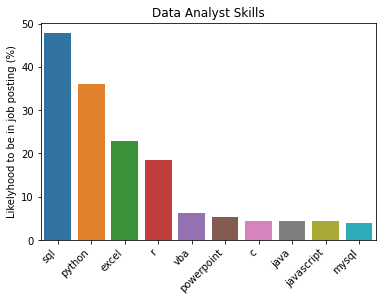

        keywords  counts  percentage
15           sql      98   47.804878
27        python      74   36.097561
80         excel      47   22.926829
138            r      38   18.536585
731          vba      13    6.341463
871   powerpoint      11    5.365854
1080           c       9    4.390244
1132        java       9    4.390244
1133  javascript       9    4.390244
1326       mysql       8    3.902439


In [28]:
#get all keywords
count_keywords=pd.DataFrame(all_jobs.tokenized_description.sum()).value_counts().rename_axis("keywords").reset_index(name="counts")
length =len(all_jobs)

count_keywords["percentage"] = 100 * count_keywords.counts / length

# plotting
count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
count_keywords = count_keywords.head(10)

graph = seaborn.barplot(x="keywords", y="percentage", data = count_keywords)
graph.set_xticklabels(graph.get_xticklabels(), 
                        rotation=45, 
                        horizontalalignment='right')
plt.xlabel("")
plt.ylabel("Likelyhood to be in job posting (%)")
plt.title("Data Analyst Skills") 
plt.show(graph)
print(count_keywords)

